In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# data is sampled at 125hz -> each sample is 8ms
# shape is {up/down/neutral, channel, sample}

data = np.load("data.npy")
data.shape

(3, 16, 15000)

### Data Exploration


1. Chunk out the data into 1s samples

2. Featurize the data & visualize features
    *
    * FFT features
        * can we see 6Hz dominant frequency?
        * can we isolate brain wave bins (alpha, etc.) and plot relative magnitudes?

3. Can we run an unsupervised clustering operation and see broader trends?

In [3]:
# Add the up/down/neutral segments together and transpose the array so it's samples-first
concat = np.concatenate(
    [data[0], data[1], data[2]],
    axis=-1
).T
concat.shape

(45000, 16)

In [4]:
# take the samples and chunk it out into 1s discrete windows
windows = concat.reshape((-1, 125, 16))
windows.shape

(360, 125, 16)

In [5]:
# do a data check to make sure we've reshaped correctly
# corresponds to "up" trial run, second window
assert np.array_equal(
    data[0,:,125:250].T,
    windows[1]
)

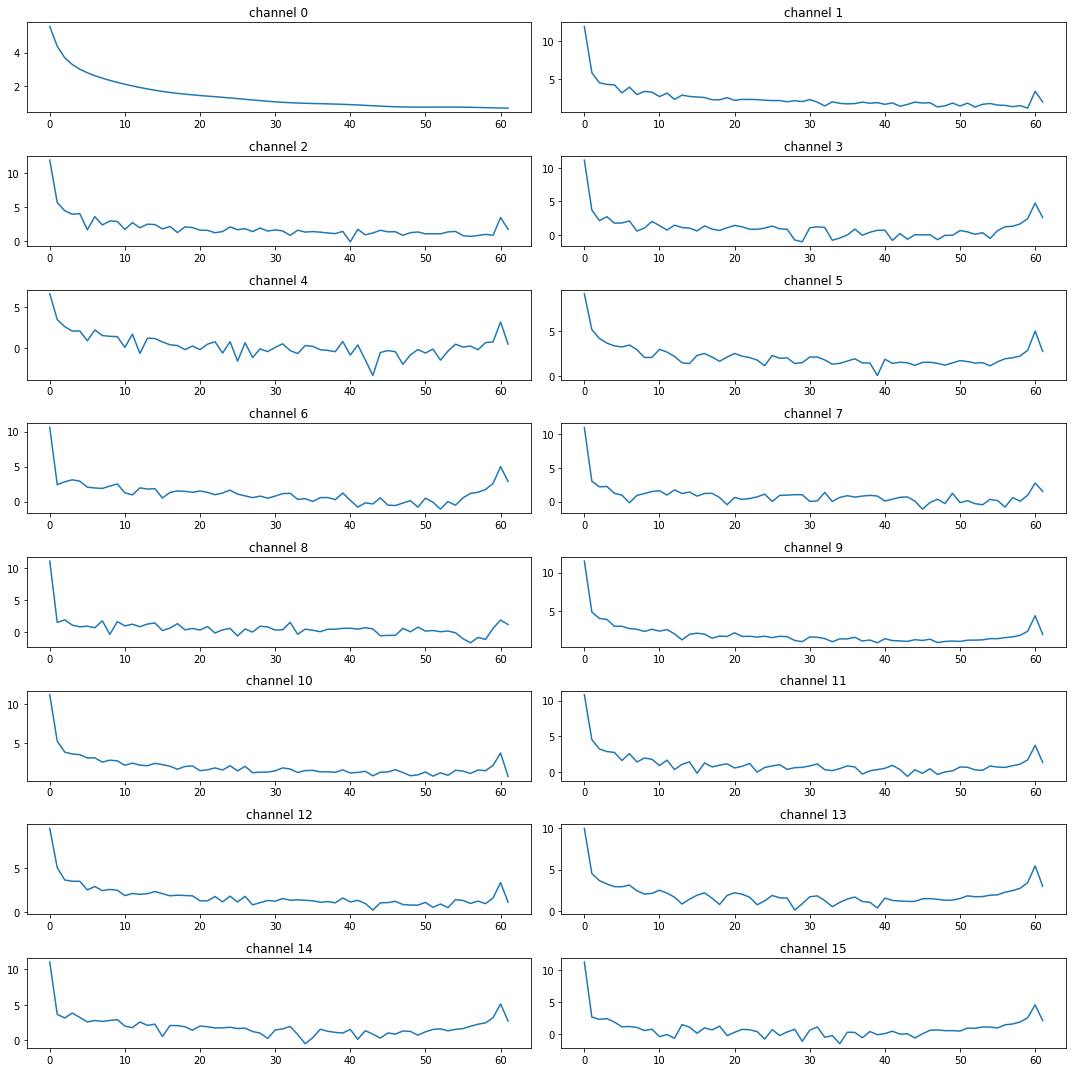

In [6]:
from scipy.fft import fft


def fft_features(sample_window):
    """
    takes an input of (125, 16) and returns (16, 8)
    for each channel, runs a FFT and outputs amplitudes for:

    assumes 1s windows of input.
    """
    
    N = sample_window.shape[0]
    channel_features = []
    for channel in range(sample_window.shape[1]):
        channel_features.append(fft(sample_window[:, channel])[:N//2])
    
    # can also choose to create frequency bins. right now, we're going from 0 -> 61Hz
    
    # log scaling here.
    return np.log(2.0/N * np.abs(np.array(channel_features)))
    

# Make sure that we're doing everything sanely. Plot the FFT for each channel
features = fft_features(windows[0])

fig, axs = plt.subplots(8, 2)
for i in range(features.shape[0]):
    axs[i//2, i%2].set_title(f"channel {i}")
    axs[i//2, i%2].plot(range(62), features[i])

fig.set_figheight(15)
fig.set_figwidth(15)
fig.tight_layout()

In [7]:
# Generate the training dataset
xs = []
ys = []
for i, example in enumerate(windows):
    features = fft_features(example)
    xs.append(features)
    if i < len(windows) // 3:
        ys.append(0)
    elif i < 2 * len(windows) // 3:
        ys.append(1)
    else:
        ys.append(2)

xs = np.array(xs)
ys = np.array(ys)

In [8]:
# 1s samples, channels, freq bins
xs.shape

(360, 16, 62)

In [9]:
# reshape for training
xs = xs.reshape((xs.shape[0], -1))
xs.shape

(360, 992)

In [10]:
# shuffle the training dataset
inds = np.random.permutation(xs.shape[0])
xs = xs[inds]
ys = ys[inds]

In [11]:
d = {}
for i in ys.tolist():
    d[i] = d.get(i, 0) + 1
print(d)

{0: 120, 1: 120, 2: 120}


In [12]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

X_train, X_test, y_train, y_test = train_test_split(xs, ys, test_size=0.3, shuffle=True)

# sss = StratifiedShuffleSplit(n_splits=5, test_size=0.4, random_state=0)
# for train_index, test_index in sss.split(xs, ys):
#     X_train, X_test = xs[train_index], xs[test_index]
#     y_train, y_test = ys[train_index], ys[test_index]
#     break

In [13]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(max_iter=300).fit(X_train, y_train)
print(f"train score: {clf.score(X_train, y_train)}")
print(f"test score: {clf.score(X_test, y_test)}")

train score: 1.0
test score: 0.9629629629629629


In [14]:
y_test

array([2, 1, 0, 0, 1, 0, 0, 1, 2, 2, 1, 2, 2, 1, 0, 2, 1, 2, 2, 0, 0, 1,
       2, 2, 1, 0, 2, 2, 0, 2, 0, 1, 2, 0, 1, 2, 0, 0, 2, 0, 2, 2, 0, 2,
       1, 0, 0, 0, 1, 0, 1, 0, 2, 0, 2, 1, 1, 2, 2, 0, 2, 2, 1, 1, 2, 1,
       1, 1, 1, 2, 1, 2, 2, 2, 2, 0, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 2, 0, 0, 2, 1, 1, 1, 0, 2, 0, 1, 2, 2, 0, 0, 1, 0, 1, 1])

In [15]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["eyes-closed", "eyes-open", "blink"]))

              precision    recall  f1-score   support

 eyes-closed       0.97      1.00      0.99        33
   eyes-open       0.95      0.95      0.95        38
       blink       0.97      0.95      0.96        37

    accuracy                           0.96       108
   macro avg       0.96      0.96      0.96       108
weighted avg       0.96      0.96      0.96       108



In [16]:
y_pred

array([2, 1, 0, 0, 1, 0, 0, 1, 2, 2, 1, 1, 2, 1, 0, 2, 0, 2, 2, 0, 0, 1,
       2, 2, 1, 0, 2, 2, 0, 2, 0, 1, 2, 0, 1, 2, 0, 0, 2, 0, 2, 2, 0, 2,
       2, 0, 0, 0, 1, 0, 1, 0, 2, 0, 2, 1, 1, 2, 2, 0, 2, 1, 1, 1, 2, 1,
       1, 1, 1, 2, 1, 2, 2, 2, 2, 0, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 2, 0, 0, 2, 1, 1, 1, 0, 2, 0, 1, 2, 2, 0, 0, 1, 0, 1, 1])

In [17]:
y_test

array([2, 1, 0, 0, 1, 0, 0, 1, 2, 2, 1, 2, 2, 1, 0, 2, 1, 2, 2, 0, 0, 1,
       2, 2, 1, 0, 2, 2, 0, 2, 0, 1, 2, 0, 1, 2, 0, 0, 2, 0, 2, 2, 0, 2,
       1, 0, 0, 0, 1, 0, 1, 0, 2, 0, 2, 1, 1, 2, 2, 0, 2, 2, 1, 1, 2, 1,
       1, 1, 1, 2, 1, 2, 2, 2, 2, 0, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 2, 0, 0, 2, 1, 1, 1, 0, 2, 0, 1, 2, 2, 0, 0, 1, 0, 1, 1])

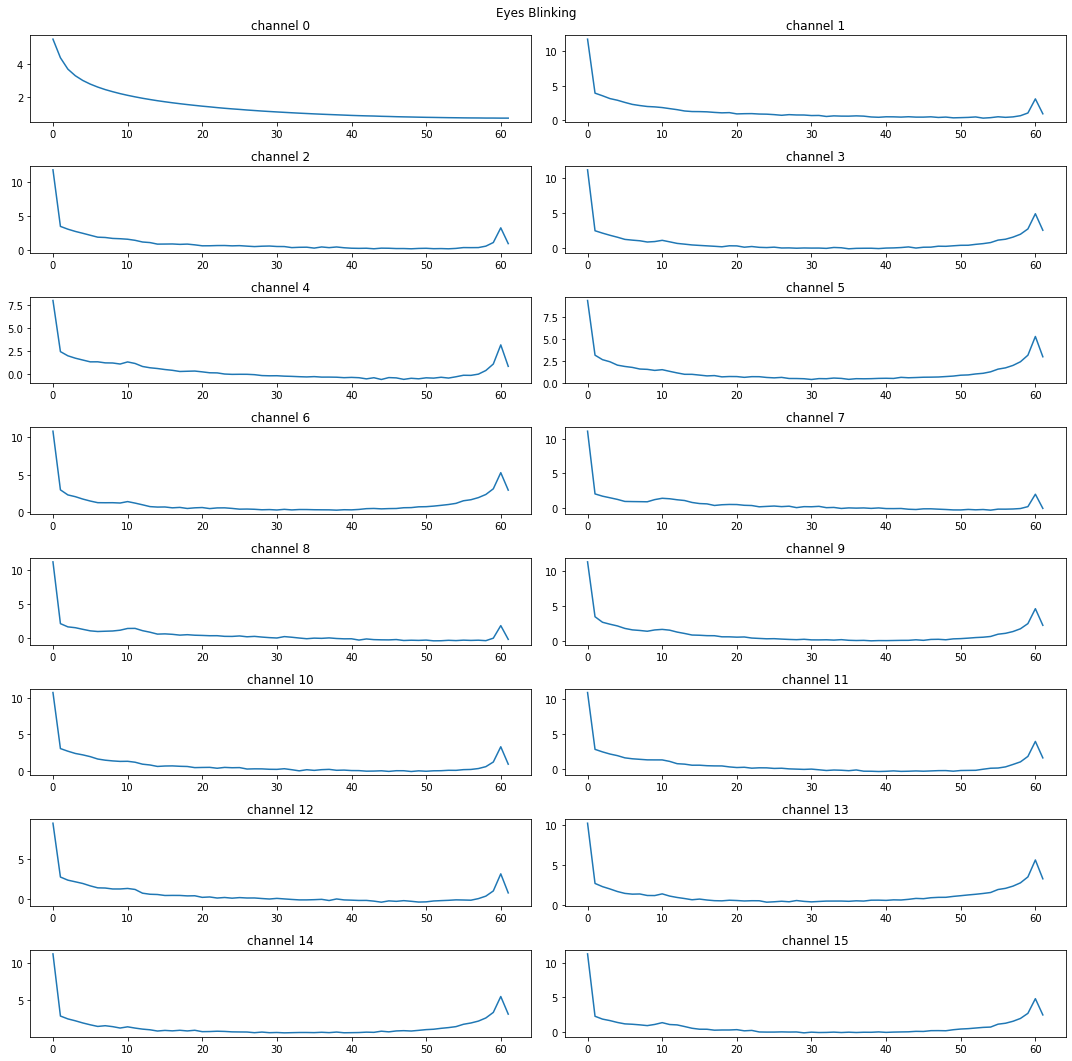

In [18]:
# eyes closed -> FFT mean
mean_features = np.mean(xs.reshape((xs.shape[0], 16, -1))[240:360], axis=0)


fig, axs = plt.subplots(8, 2)
for i in range(features.shape[0]):
    axs[i//2, i%2].set_title(f"channel {i}")
    axs[i//2, i%2].plot(range(62), mean_features[i])

fig.suptitle("Eyes Blinking")

fig.set_figheight(15)
fig.set_figwidth(15)
fig.tight_layout()

plt.show()